In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
import os
import cv2
import numpy as np
import random

def check_image_path(directory):
    # Modify this function to return the valid image file paths from the directory.
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def random_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    """
    Apply random brightness and contrast adjustments to the image.
    
    Args:
        image (np.array): The image to adjust
        alpha_range (tuple): The range for contrast (scaling factor)
        beta_range (tuple): The range for brightness (additive factor)
    
    Returns:
        np.array: The adjusted image
    """
    alpha = random.uniform(*alpha_range)  # Random contrast factor
    beta = random.randint(*beta_range)  # Random brightness factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def read_xray_images(directory_path, img_height, img_width, augmentation=False):
    """
    Reads X-ray image data from directories, resizes images to the same size & performs cautious augmentation.

    Args:
      directory_path (str): Path to the main directory containing class subdirectories (e.g., Atelectasis, Pneumonia)
      img_height (int): Height of image to resize to
      img_width (int): Width of image to resize to
      augmentation (bool): Whether to perform data augmentation or not

    Returns:
      datax (np.array): NumPy array of images
      datay (np.array): NumPy array of labels (class names)
    """

    datax = []  # list to hold the images
    datay = []  # list to hold the image labels

    # Get a list of the subdirectories in the main directory (diseases)
    sub_directories = os.listdir(directory_path)

    for sub_dir in sub_directories:  # For each subdirectory (disease class), read the images
        sub_dir_path = os.path.join(directory_path, sub_dir)

        # Check that image file paths are valid, avoid broken paths
        correct_image_filepaths = check_image_path(sub_dir_path)

        for fpath in correct_image_filepaths:  # Loop through the image file paths

            # Read the image (in BGR format)
            image = cv2.imread(fpath)

            # Convert to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize image to a uniform size
            image = cv2.resize(image, (img_width, img_height))

            # Perform cautious data augmentation if enabled
            if augmentation:
                # Apply random brightness and contrast adjustments
                image = random_brightness_contrast(image)

                # Mild rotation (90 degrees)
                if random.random() < 0.5:  # 50% chance to rotate
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

                # Extend the data with augmented versions of the image
                datax.append(image)
                datay.append(sub_dir + '_aug')

            else:  # For validation or test data, no augmentation
                datax.append(image)
                datay.append(sub_dir)  # The disease name as label

    return np.array(datax), np.array(datay)

In [6]:
################################# VGG19 ##############################################

vgg19_model = models.vgg19(pretrained=True)

################################# ResNet50 ###########################################

resnet50_model = models.resnet50(pretrained=True)

################################# DenseNet121 ########################################

densenet121_model = models.densenet121(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 229MB/s]  
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future

In [7]:
vgg19_model = vgg19_model.to(device)
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
resnet50_model = resnet50_model.to(device)
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
densenet121_model = densenet121_model.to(device)
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
################################# VGG19 ########################################

summary(vgg19_model, (3, 224, 224), device=device)

################################# ResNet50 #####################################

summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

In [11]:
summary(densenet121_model, (3, 224, 244), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

In [12]:
########################## VGG19 #############################
for name, module in vgg19_model.named_modules():
    print(name)

########################## ResNet50 #############################
for name, module in resnet50_model.named_modules():
    print(name)

########################## DenseNet121 #############################
for name, module in densenet121_model.named_modules():
    print(name)
     


features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
features.31
features.32
features.33
features.34
features.35
features.36
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6

conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1

In [13]:
# VGG19 --> check the names of the modules and their children
print(f"---Main modules---:")
for name, module in vgg19_model.named_children():
    print(name)

# we are interested in the features module since it contains the conv layers we want to unfreeze
print(f"---Child Modules for the 'features' module")
for name, module in vgg19_model.named_children():
    if name == "features":
        for n, m in module.named_children():
            print(n)

---Main modules---:
features
avgpool
classifier
---Child Modules for the 'features' module
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [14]:
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)

# Lets say you are interested in layer4
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


In [15]:
print(f"---Main modules---:")
for name, module in densenet121_model.named_children():
    print(name)


for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x in ["denselayer15", "denselayer16"]:
                        for param in y.parameters():
                            print(x, y)

---Main modules---:
features
classifier
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)
denselayer15 _DenseLayer(
  (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=

In [16]:
######################### VGG19 ##############################
for param in vgg19_model.parameters():
    param.requires_grad = False

######################### ResNet50 ##############################
for param in resnet50_model.parameters():
    param.requires_grad = False

######################### DenseNet121 ##############################
for param in densenet121_model.parameters():
    param.requires_grad = False

In [17]:
vgg19_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg19_model.classifier = nn.Flatten()
summary(vgg19_model, (3, 224, 224), device=device)

####################################### ResNet50 ######################################

resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)

###################################### DenseNet121 ####################################

densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

In [18]:
for param in vgg19_model.features[34:].parameters():
    param.requires_grad = True

In [19]:
for param in resnet50_model.layer4[2:].parameters():
    param.requires_grad = True

In [20]:
# DenseNet121 --> unfreeze denselayer 16. It contains 2 conv layers
for name, child_module in densenet121_model.named_children():
    if name == "features":
        for n, m in child_module.named_children():
            #print(n)
            if n == "denseblock4":
                for x, y in m.named_children():
                    #print(x)
                    if x == "denselayer16":
                        for param in y.parameters():
                            param.requires_grad = True

# also unfreeze the 'features.norm5' layers
for name, module in densenet121_model.features.named_children():
    if name == "norm5":
        for param in module.parameters():
            param.requires_grad = True


In [21]:

for param in densenet121_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [22]:

summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

In [23]:

img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/few-shot-data/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/few-shot-data/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/few-shot-data/Few Shot Algorithm/Testing"

In [24]:
%%time
# get training data
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=True)

CPU times: user 3.21 s, sys: 766 ms, total: 3.98 s
Wall time: 4.99 s


In [25]:
x_train.shape, y_train.shape

((120, 224, 224, 3), (120,))

In [26]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=True)

In [27]:
x_val.shape, y_val.shape

((60, 224, 224, 3), (60,))

In [28]:
import sys


sys.path.append('/kaggle/input/scriptss/other/default/1')

import prototypical_network
import train_and_evaluation

Class labels sampled: ['Atelectasis_aug' 'Cardiomegaly_aug' 'Covid19_aug' 'Fibrosis_aug']


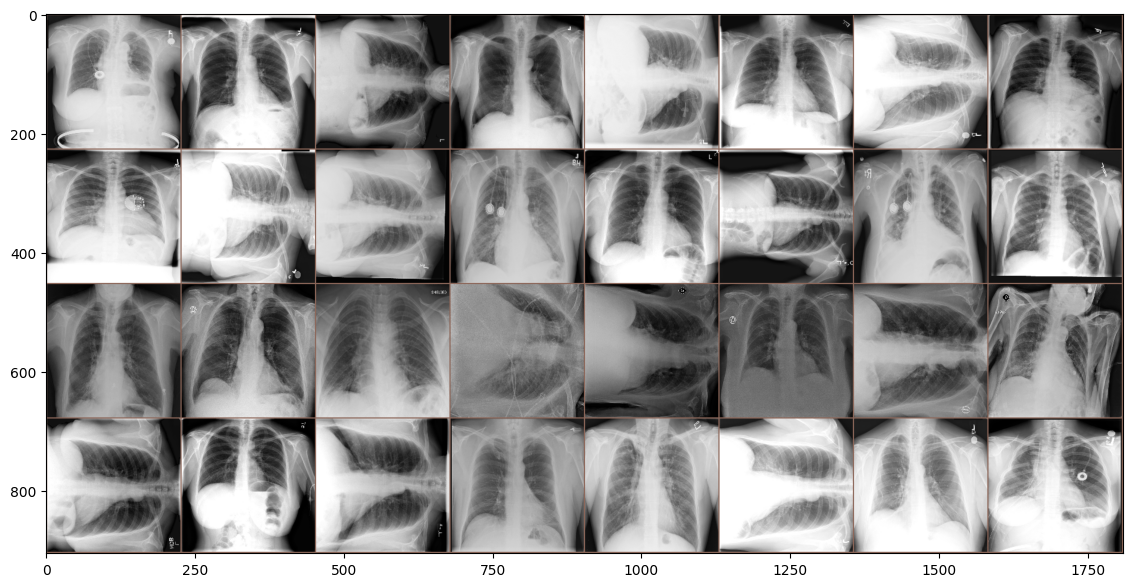

In [29]:
n_way = 4     # no. of classes --> Remember due to augmentation we now have 30 classes to sample from
n_support = 5 # no. of support images per class
n_query = 3   # no. of query images per class
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train) #  returns a dictionary
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

In [30]:
model = prototypical_network.ProtoNet(densenet121_model, device)
model.to(device)

# you need to use a very low learning rate
basic_learning_rate = 0.0001

# we only want to update the layers that we unfroze in the model
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       # n_way <= No. of unique classes in the validation set
n_support = 10   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "DenseNet121-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 4.631 | Train Acc: 66.00%
	 Val. Loss: 8.275 | Val. Acc: 61.00%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 5.673 | Train Acc: 62.50%
	 Val. Loss: 5.790 | Val. Acc: 64.50%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 6.315 | Train Acc: 65.00%
	 Val. Loss: 6.912 | Val. Acc: 61.75%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 5.722 | Train Acc: 64.50%
	 Val. Loss: 7.228 | Val. Acc: 65.00%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 5.651 | Train Acc: 68.50%
	 Val. Loss: 7.111 | Val. Acc: 62.50%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 4.791 | Train Acc: 66.00%
	 Val. Loss: 7.513 | Val. Acc: 60.75%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 5.135 | Train Acc: 67.00%
	 Val. Loss: 7.136 | Val. Acc: 62.25%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 5.027 | Train Acc: 66.00%
	 Val. Loss: 7.225 | Val. Acc: 64.50%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 5.180 | Train Acc: 69.75%
	 Val. Loss: 6.889 | Val. Acc: 63.00%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 4.912 | Train Acc: 69.00%
	 Val. Loss: 5.877 | Val. Acc: 66.50%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 5.528 | Train Acc: 59.25%
	 Val. Loss: 5.869 | Val. Acc: 62.75%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 4.136 | Train Acc: 70.25%
	 Val. Loss: 6.187 | Val. Acc: 62.75%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 5.345 | Train Acc: 60.50%
	 Val. Loss: 5.358 | Val. Acc: 68.00%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 4.351 | Train Acc: 70.00%
	 Val. Loss: 6.480 | Val. Acc: 64.50%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 5.147 | Train Acc: 68.75%
	 Val. Loss: 8.368 | Val. Acc: 60.75%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 5.202 | Train Acc: 67.75%
	 Val. Loss: 6.391 | Val. Acc: 62.00%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 4.319 | Train Acc: 70.75%
	 Val. Loss: 6.954 | Val. Acc: 60.50%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 5.661 | Train Acc: 62.75%
	 Val. Loss: 7.664 | Val. Acc: 59.00%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 4.455 | Train Acc: 68.25%
	 Val. Loss: 6.523 | Val. Acc: 62.75%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 4.283 | Train Acc: 69.50%
	 Val. Loss: 7.534 | Val. Acc: 61.25%


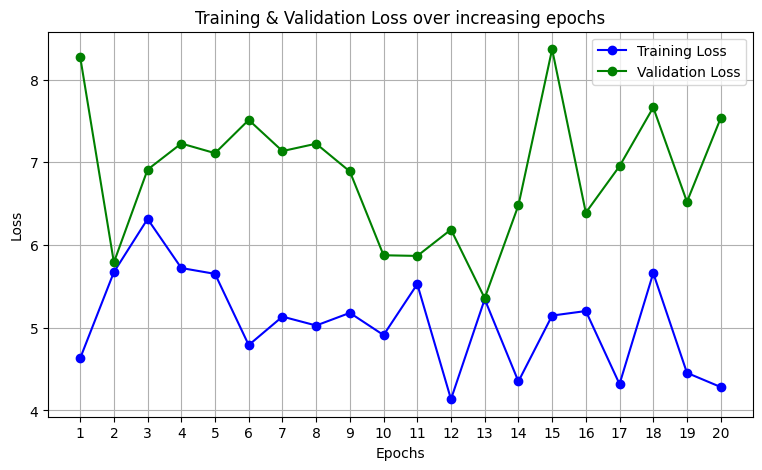

/tmp/ipykernel_30/3786377200.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


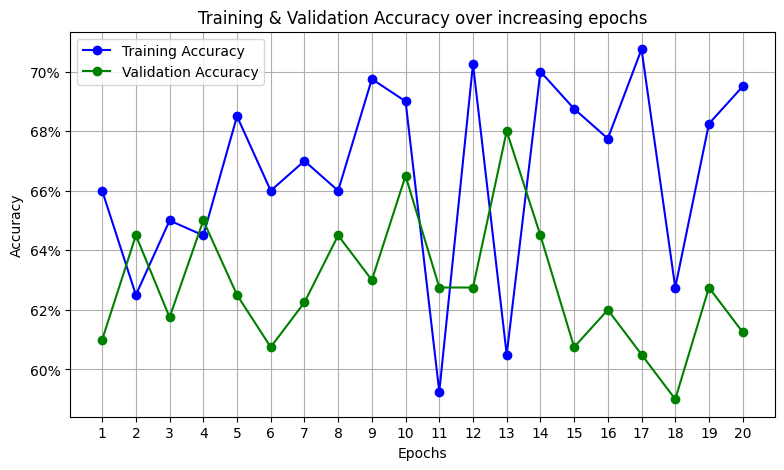

In [31]:
epochs = np.arange(max_epoch) + 1
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Training & Validation Loss over increasing epochs')
plt.plot(epochs, train_loss_list,'bo-', label='Training Loss')
plt.plot(epochs, validation_loss_list,'go-', label='Validation Loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(122)
plt.title('Training & Validation Accuracy over increasing epochs')
plt.plot(epochs, train_accuracy_list, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy_list, 'go-', label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()
     

In [32]:
d = []

# loop through loss and accuracy values
for epoch, (train_loss, validation_loss, train_acc, validation_acc) in enumerate(zip(train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list)):
  
  d.append({"Epoch": epoch, "Training_Loss": train_loss, "Validation_loss": validation_loss, "Training_Acc": train_acc, "Validation_Acc": validation_acc})
     

In [33]:

temp_dataframe = pd.DataFrame(d)
temp_dataframe.head()

,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,4.631039,8.274982,0.660,0.6100
1,1,5.672754,5.789848,0.625,0.6450
2,2,6.315435,6.912301,0.650,0.6175
3,3,5.722301,7.227686,0.645,0.6500
4,4,5.651488,7.111089,0.685,0.6250


In [34]:
temp_dataframe.to_csv('DenseNet121-Acc-Loss.csv')

In [35]:
DenseNet121_dataframe = pd.read_csv("DenseNet121-Acc-Loss.csv")
DenseNet121_dataframe.head()

,Unnamed: 0,Epoch,Training_Loss,Validation_loss,Training_Acc,Validation_Acc
0,0,0,4.631039,8.274982,0.660,0.6100
1,1,1,5.672754,5.789848,0.625,0.6450
2,2,2,6.315435,6.912301,0.650,0.6175
3,3,3,5.722301,7.227686,0.645,0.6500
4,4,4,5.651488,7.111089,0.685,0.6250


In [36]:
img_height, img_width = 224, 224
data_dir = test_data_dir
x_test, y_test = read_xray_images(data_dir, img_height, img_width, augmentation=False)

In [37]:
x_test.shape, y_test.shape

((60, 224, 224, 3), (60,))

In [ ]:
prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 1
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 19.384, Accuracy: 0.55
Episode: 100 ---> Loss: 67.797, Accuracy: 0.50
Episode: 200 ---> Loss: 30.124, Accuracy: 0.50
Episode: 300 ---> Loss: 20.201, Accuracy: 0.55
Episode: 400 ---> Loss: 16.066, Accuracy: 0.45
Episode: 500 ---> Loss: 23.679, Accuracy: 0.40
Episode: 600 ---> Loss: 85.303, Accuracy: 0.50
Episode: 700 ---> Loss: 19.080, Accuracy: 0.55
Episode: 800 ---> Loss: 28.320, Accuracy: 0.50
Episode: 900 ---> Loss: 22.310, Accuracy: 0.55
Episode: 1000 ---> Loss: 80.251, Accuracy: 0.55
Episode: 1100 ---> Loss: 31.023, Accuracy: 0.30
Episode: 1200 ---> Loss: 20.237, Accuracy: 0.45
Episode: 1300 ---> Loss: 45.481, Accuracy: 0.65
Episode: 1400 ---> Loss: 68.998, Accuracy: 0.50
Episode: 1500 ---> Loss: 38.427, Accuracy: 0.50
Episode: 1600 ---> Loss: 16.577, Accuracy: 0.45
Episode: 1700 ---> Loss: 31.169, Accuracy: 0.45
Episode: 1800 ---> Loss: 10.683, Accuracy: 0.70
Episode: 1900 ---> Loss: 28.209, Accuracy: 0.45
Episode:

In [ ]:
prototypical_model.to(device)
n_way = 2
n_support = 1
n_query = 10 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [ ]:
model = prototypical_network.ProtoNet(resnet50_model, device)
model.to(device)

# you need to use a very low learning rate
basic_learning_rate = 0.0001

# we only want to update the layers that we unfroze in the model
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       # n_way <= No. of unique classes in the validation set
n_support = 10   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

# name to save model as
filename = "resnet50-best-few-shot-model.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)


In [ ]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 1
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")